In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn import linear_model

## 1.
Скачайте данные в формате csv, выберите из таблицы данные по России, начиная с 3 марта 2020 г. (в этот момент впервые стало больше 2 заболевших). В качестве целевой переменной возьмём число случаев заболевания (столбцы total_cases и new_cases); для упрощения обработки можно заменить в столбце new_cases все нули на единицы. Для единообразия давайте зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта; остальные данные можно использовать в качестве тестового набора (и он даже будет увеличиваться по мере выполнения задания).


In [2]:
df = pd.read_csv('owid-covid-data.csv')
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df[(df['iso_code'] == "RUS") & (df['date'] >= datetime.datetime(2020, 3, 3))]
df = df.set_index('date')
df['total_cases_log'] = df['total_cases'].apply(lambda x: np.log(x))
train_size = 50
train = df[:train_size]
test = df[train_size:]
y_train = train['total_cases_log']
X_train = np.array(range(0, y_train.size)).reshape(-1, 1)
y_test = test['total_cases_log']
X_test = np.array(range(y_train.size, y_train.size + y_test.size)).reshape(-1, 1)
# y_full = df['total_cases_log']
# X_full = np.array(range(0, y_full.size))

In [3]:
df.head()

,iso_code,location,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,...,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_100k,total_cases_log
date,,,,,,,,,,,,,,,,,,,,,
2020-03-03,RUS,Russia,3,1,0,0,0.021,0.007,0.0,0.0,...,9.393,24765.954,0.1,431.297,6.18,23.4,58.3,NaN,8.05,1.098612
2020-03-04,RUS,Russia,4,1,0,0,0.027,0.007,0.0,0.0,...,9.393,24765.954,0.1,431.297,6.18,23.4,58.3,NaN,8.05,1.386294
2020-03-05,RUS,Russia,4,0,0,0,0.027,0.000,0.0,0.0,...,9.393,24765.954,0.1,431.297,6.18,23.4,58.3,NaN,8.05,1.386294
2020-03-06,RUS,Russia,4,0,0,0,0.027,0.000,0.0,0.0,...,9.393,24765.954,0.1,431.297,6.18,23.4,58.3,NaN,8.05,1.386294
2020-03-07,RUS,Russia,10,6,0,0,0.069,0.041,0.0,0.0,...,9.393,24765.954,0.1,431.297,6.18,23.4,58.3,NaN,8.05,2.302585


## 2. 
Постройте графики целевых переменных. Вы увидите, что число заболевших растёт очень быстро, на первый взгляд экспоненциально. Для первого подхода к снаряду давайте это и используем.


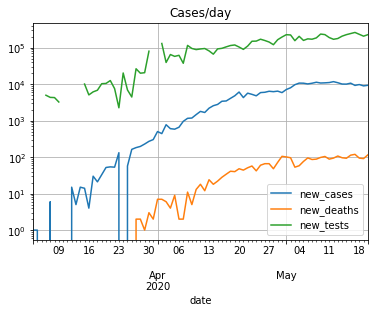

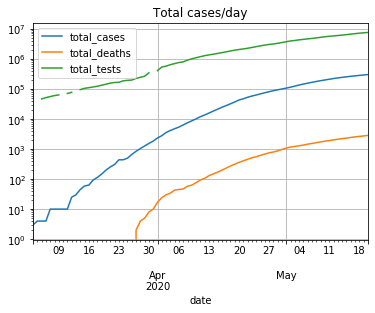

In [4]:
df[["new_cases","new_deaths","new_tests"]].plot(logy=True, title='Cases/day', grid=True)
df[["total_cases","total_deaths","total_tests"]].plot(logy=True, title='Total cases/day', grid=True)

### 2.a. 
Используя линейную регрессию, обучите модель с экспоненциальным ростом числа заболевших: y ~ exp(линейная функция от x), где x — номер текущего дня.

In [5]:
model = linear_model.LinearRegression(fit_intercept=True).fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

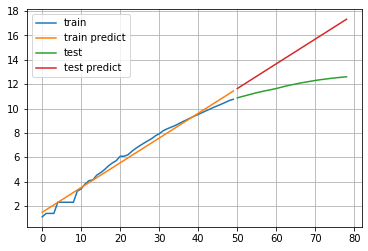

In [6]:
_, ax = plt.subplots()
ax.plot(X_train, y_train, label = "train")
ax.plot(X_train, pred_train, label = "train predict")
ax.plot(X_test, y_test, label = "test")
ax.plot(X_test, pred_test, label = "test predict")
ax.grid()
plt.legend()
plt.show()

### 2.b
Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).

In [7]:
post_sigma = (y_train - pred_train).std()
post_sigma # сигма, которая будет использоваться в для оценки правдоподобия распределения коэффициентов

0.3624927139710254

In [8]:
# Веса полученной модели, которые будем использовать как средние значения априорного распределения
w0 = model.intercept_
w1 = model.coef_[0]
w = [w0, w1]
print ("Веса полученной модели:\n", w)

Веса полученной модели:
 [1.4789565694775932, 0.20328037440019608]


Мы знаем "реальные" веса модели, полученные при помощи МНК. Теперь сделаем байесовский вывод для линейной регрессии и получим веса другим путём.
Начальные веса для априорного распределения возьмём (0,0)

In [9]:
from scipy.stats import multivariate_normal
def get_pos(mu, sigma):
    dw0 = abs(mu[0] - w[0]) * 2 + 3 * sigma[0][0]
    dw1 = abs(mu[1] - w[1]) * 2 + 3 * sigma[1][1]
    xl = cur_mu[0] - dw0
    xr = cur_mu[0] + dw0
    yl = cur_mu[1] - dw1
    yr = cur_mu[1] + dw1
    X = np.linspace(xl, xr, N)
    Y = np.linspace(yl, yr, N)
    X, Y = np.meshgrid(X, Y)
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y
    return pos

N = 250
def generate_heatmap(cur_mu, cur_sigma, Z=None):
    dw0 = abs(cur_mu[0] - w[0]) * 2 + 3 * cur_sigma[0][0]
    dw1 = abs(cur_mu[1] - w[1]) * 2 + 3 * cur_sigma[1][1]
    xl = cur_mu[0] - dw0
    xr = cur_mu[0] + dw0
    yl = cur_mu[1] - dw1
    yr = cur_mu[1] + dw1
    X = np.linspace(xl, xr, N)
    Y = np.linspace(yl, yr, N)
    X, Y = np.meshgrid(X, Y)
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y
    if Z is None:
        Z = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)
    # Make the plot
    plt.xlim((xl, xr))
    plt.ylim((yl, yr))
    plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)
    plt.scatter(w[0], w[1], marker='*', s=120)
    plt.show()

Создадим априорное распределение с центрами в [0,0] и дисперсиями[2,2]

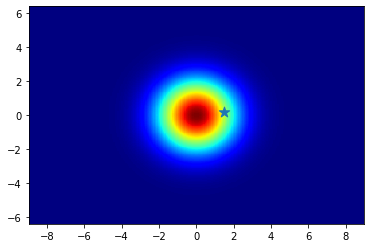

In [10]:
cur_mu, cur_sigma = np.array([0, 0]), 2*np.array([[1, 0], [0, 1]])
generate_heatmap(cur_mu, cur_sigma)

In [11]:
xd = X_train
data = y_train

In [12]:
def get_likelihood(px, py):
    return lambda x : np.exp(-2*(x[0] + x[1]*px - py) ** 2) / (post_sigma * np.sqrt(2.*np.pi))

def plot_likelihood(px, py):
    cur_likelihood = get_likelihood(px, py)
    pos = get_pos(cur_mu, cur_sigma)
    Z = np.array([[ cur_likelihood(pos[i, j]) for j in range(pos.shape[1])] for i in range(pos.shape[0])])
    generate_heatmap(cur_mu, cur_sigma, Z)

Нарисуем правдоподобие нашей модели для 1й точки датасета

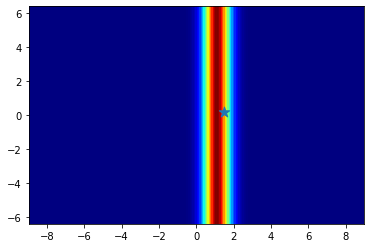

Правдоподобие нашей модели для 1й точки датасете


In [13]:
px, py = xd[0][0], data[0]
plot_likelihood(px, py)
print("Правдоподобие нашей модели для 1й точки датасете")

In [14]:
def bayesian_update(mu, sigma, x_matrix, y, post_sigma):
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (post_sigma ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (post_sigma ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n

def bayes_range(mu, sigma, num_steps):
    for i in range(0, num_steps):
        mu, sigma = bayesian_update(mu, sigma, np.array([[1, xd[i][0]]]), data[i], post_sigma) 
    print("Веса после МНК", w)
    print("Веса после Байеса, (", num_steps, " точек)", mu)
    return mu, sigma

Сравним известные нам веса и веса, полученные после первой итерации обновления весов априорного распределения N([0,0], 2)

Веса после МНК [1.4789565694775932, 0.20328037440019608]
Веса после Байеса, ( 1  точек) [1.03088279 0.        ]


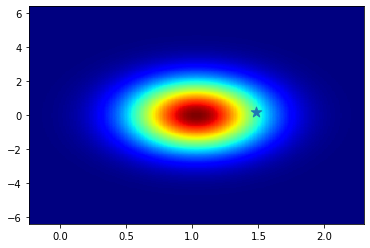

In [15]:
mu1, sigma1 = bayes_range(cur_mu, cur_sigma, 1)
generate_heatmap(mu1, sigma1)

Видно, что уже после первого байесовского шага мы существенно приблизились к истинным значениям. Повторим ещё для 49 точек

Веса после МНК [1.4789565694775932, 0.20328037440019608]
Веса после Байеса, ( 50  точек) [1.47148134 0.20350657]


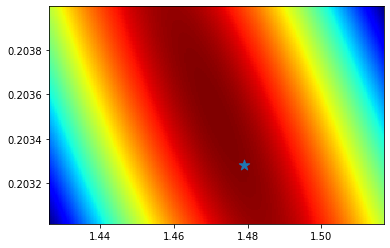

In [16]:
mu50, sigma50 = bayes_range(cur_mu, cur_sigma, 50)
generate_heatmap(mu50, sigma50)

Получили практически идентичные результаты

### 2. c. 
Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая? к 1 июня? к 1 сентября? Постройте предсказательные распределения (можно эмпирически, исходя из данных сэмплирования).

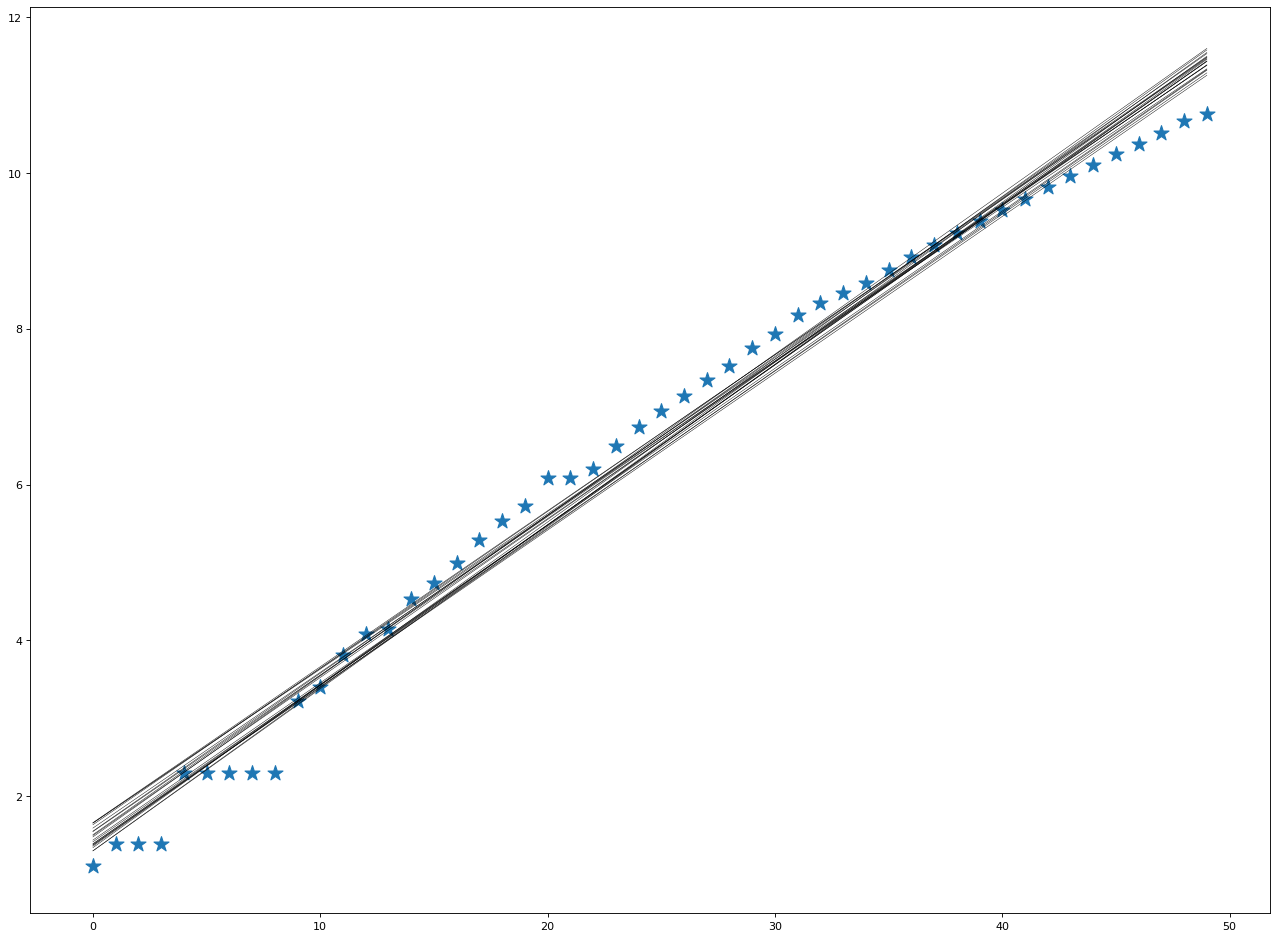

In [17]:
def myplot_sample_lines(mu, sigma, n=20, points=None):
    # Посэмплируем и порисуем прямые
    my_w = np.random.multivariate_normal(mu, sigma, n)
    plt.figure(figsize=(20, 15), dpi=80)
    for w in my_w:
        plt.plot(xd, w[0] + w[1]*xd, 'k-', lw=.4)
    if not points is None:
        plt.scatter(points[0], points[1], marker='*', s=200)
    plt.show()
myplot_sample_lines(mu50, sigma50, points=[xd, data])

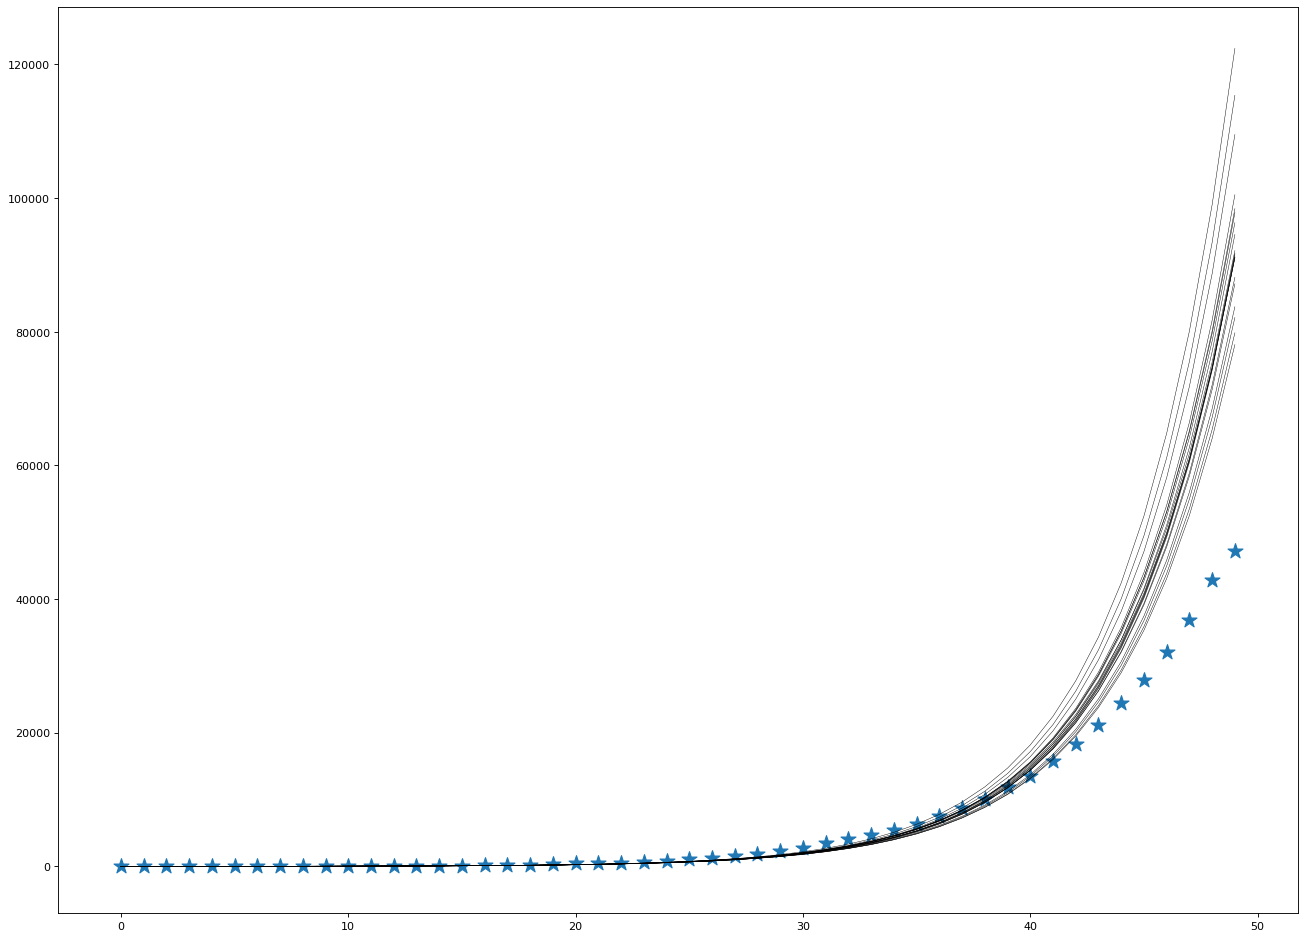

In [18]:
def myplot_sample_lines_exp(mu, sigma, n=20, points=None):
    # Посэмплируем и порисуем прямые
    my_w = np.random.multivariate_normal(mu, sigma, n)
    plt.figure(figsize=(20, 15), dpi=80)
    for w in my_w:
        plt.plot(xd, np.exp(w[0] + w[1]*xd), 'k-', lw=.4)
    if not points is None:
        plt.scatter(points[0], np.exp(points[1]), marker='*', s=200)
    plt.show()
myplot_sample_lines_exp(mu50, sigma50, points=[xd, data])

Сразу хочется отметить, что на графике мы наблюдаем растущую дисперсию в конце, а значит, наше предположение о том, что функция роста числа заболевших экспоненциальна, скорее всего, неверно.

In [19]:
march_3_date = datetime.datetime(2020, 3, 3)
def predict_ill_num(date):
    interval = (date - march_3_date).days
    y = model.predict([[interval]])
    print("Прогноз на ", date.strftime("%b-%d"),": ", int(np.exp(y)), " заболевших")
predict_ill_num(datetime.datetime(2020, 5, 1))
predict_ill_num(datetime.datetime(2020, 6, 1))
predict_ill_num(datetime.datetime(2020, 9, 1))

Прогноз на  May-01 :  709629  заболевших
Прогноз на  Jun-01 :  387098703  заболевших
Прогноз на  Sep-01 :  51275256962442904  заболевших


### 3

Предсказания экспоненциальной модели наверняка получились грустными. Но это, конечно, чересчур пессимистично — экспоненциальный рост в природе никак не может продолжаться вечно. Кривая общего числа заболевших во время эпидемии в реальности имеет сигмоидальный вид: после начальной фазы экспоненциального роста неизбежно происходит насыщение. В качестве конкретной формы такой сигмоиды давайте возьмём форму функции распределения для гауссиана:
$$
\Phi(x) = \frac{1}{\sqrt{2 \pi}}\int_{-\infty}^{x}{e^{\frac{-t^2}{2}}dt}
$$  
Естественно, в нашем случае сигмоида стремится не к единице, т.е. константа перед интегралом может быть произвольной (и её можно внести в экспоненту), а в экспоненте под интегралом может быть произвольная квадратичная функция от t.


### 3.a
> Предложите способ обучать параметры такой сигмоидальной функции при помощи линейной регрессии.

Можно предсказывать не саму функцию, а её производную, которая будет равняться
$$
f(x) = \frac{1}{\sqrt{2 \pi}}e^{at^2 + bt + c}
$$



Логарифм такой производной будет
$$
\ln{f(x)} = at^2 + bt + c
$$

Его и будем предсказывать.

Значения уже лежат в поле `new_cases`, необходимо только взять от них логарифм, как мы уже сделали ранее для поля `total_cases`

In [20]:
def get_square_arg(size, offset=0):
    x = np.zeros((size, 2))
    for i in range (size):
        x[i][0] = (i + offset)
        x[i][1] = x[i][0] ** 2
    return x

def get_sigmoid_data(df, train_size=50):
    df['new_cases_log'] = df['new_cases'].apply(lambda x: 0 if x == 0 else np.log(x))
    train = df[:train_size]
    test = df[train_size:]
    y_train = train['new_cases_log']
    X_train = get_square_arg(y_train.size)
    y_test = test['new_cases_log']
    X_test = get_square_arg(y_test.size, y_train.size)
    return X_train, y_train, X_test, y_test

def prefix_exp_sum(arr, offset=0):
    res = arr.copy()
    res = np.exp(res)
    res[0] += offset
    for i in range(1, res.size):
        res[i] += res[i - 1]
    return res

def pred_sigmoid(pred_func, X, offset=0):
    pred = pred_func(X)
    sigmoid = prefix_exp_sum(pred, offset)
    return pred, sigmoid

def prepare_data_raw_and_pred(train_size=50):
    X_train, y_train, X_test, y_test = get_sigmoid_data(df, train_size)
    X_future = get_square_arg(250, y_train.size + y_test.size)

    model = linear_model.LinearRegression(fit_intercept=True).fit(X_train, y_train)

    ys_train = prefix_exp_sum(y_train)
    ys_test = prefix_exp_sum(y_test, ys_train[-1])
    p_train, ps_train = pred_sigmoid(model.predict, X_train)
    p_test, ps_test = pred_sigmoid(model.predict, X_test, ps_train[-1])
    p_fut, ps_fut = pred_sigmoid(model.predict, X_future, ps_test[-1])
    
    post_sigma = (y_train - p_train).std()
    return [[X_train, y_train, ys_train, p_train, ps_train],
            [X_test, y_test, ys_test, p_test, ps_test],
            [X_future, None, None, p_fut, ps_fut]], post_sigma

def plot_with_train_size(get_data, train_size):
    data, _ = get_data(train_size)
    X_train = data[0][0]
    ys_train = data[0][2]
    ps_train = data[0][4]
    X_test = data[1][0]
    ys_test = data[1][2]
    ps_test = data[1][4]
    X_fut = data[2][0]
    ps_fut = data[2][4]
    
    _, ax = plt.subplots(figsize=(20, 15))
    ax.plot(X_train.T[0], ys_train, label = "train")
    ax.plot(X_train.T[0], ps_train, label = "train predict")
    ax.plot(X_test.T[0], ys_test, label = "test")
    ax.plot(X_test.T[0], ps_test, label = "test predict")
    ax.plot(X_fut.T[0], ps_fut, label = "future predict")
    ax.grid()
    plt.legend()
    plt.show()

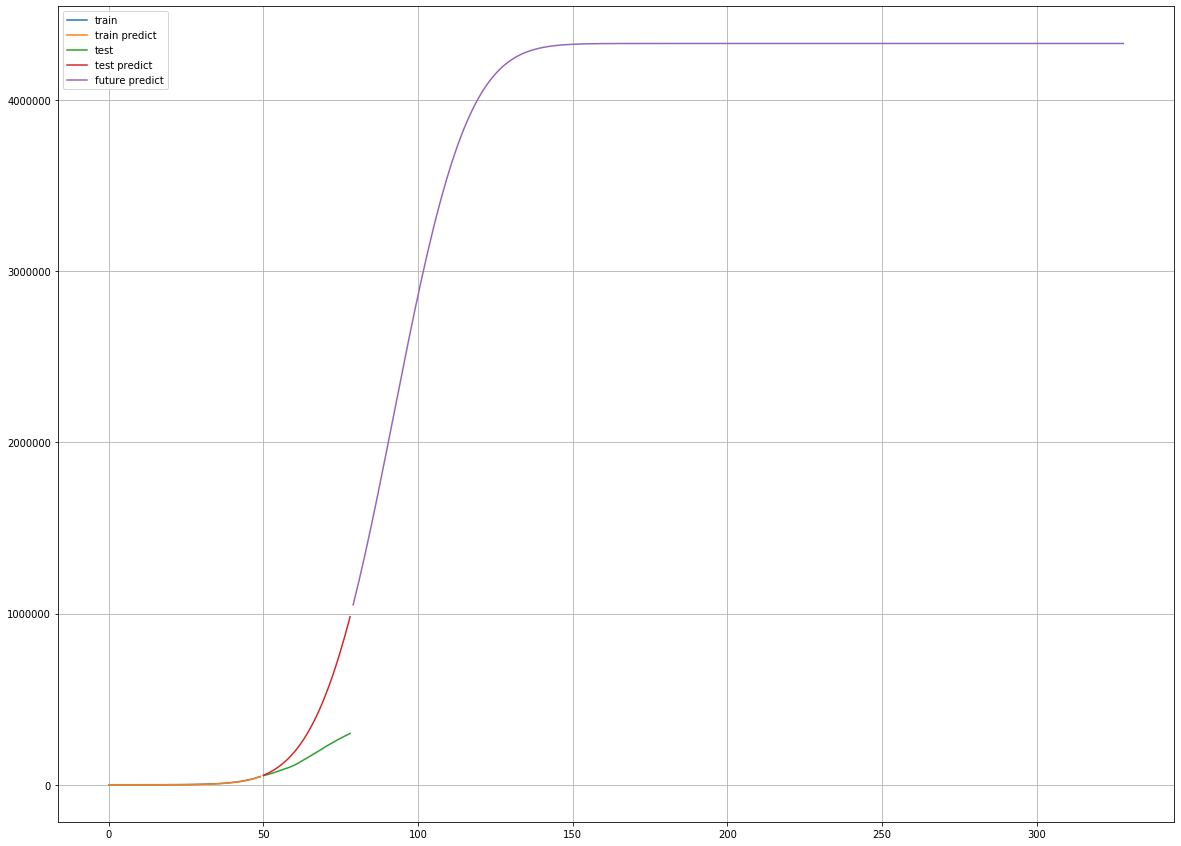

In [21]:
plot_with_train_size(prepare_data_raw_and_pred, 50)

Похоже, что 50 значений в обучающем множестве немного маловато для того, чтобы прогноз попадал в тестовые данные. Попробуем взять число побольше, например, 65

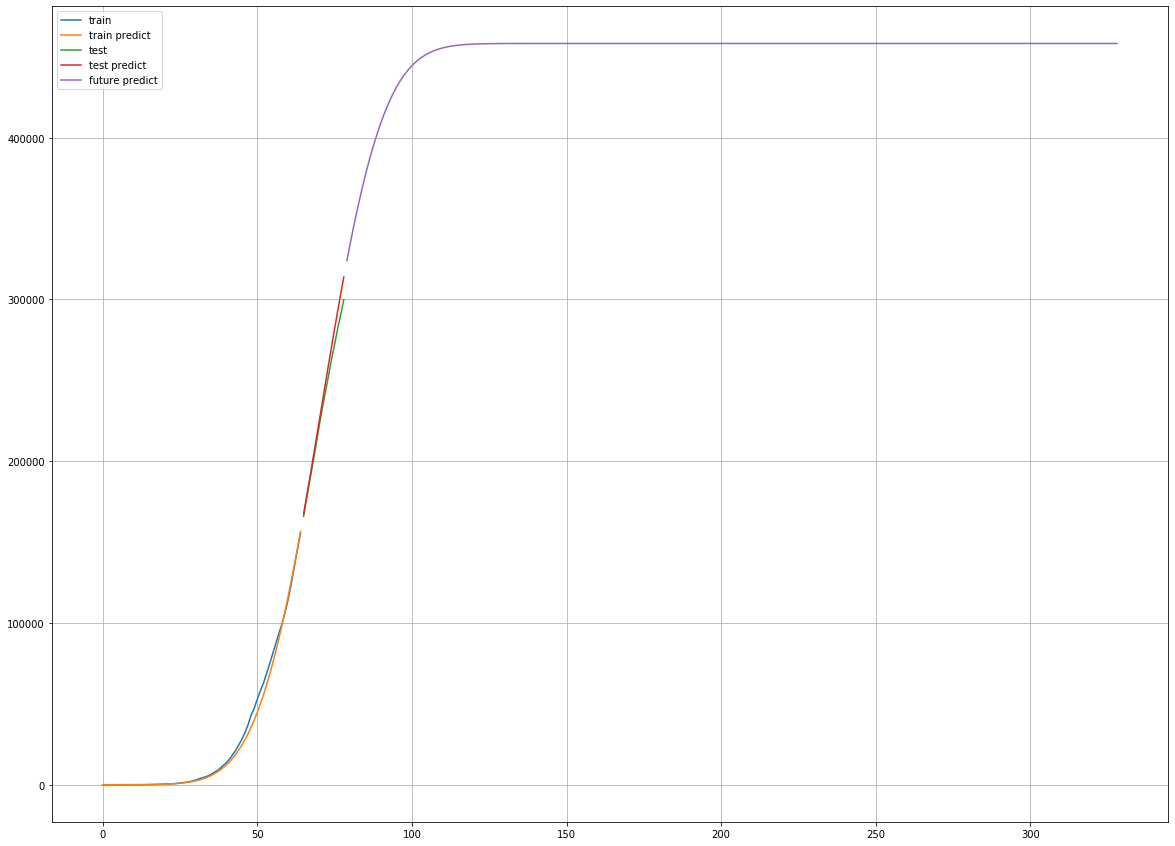

In [22]:
plot_with_train_size(prepare_data_raw_and_pred, 65)

Все ещё не идеально, но остановимся на этой цифре

### 3.b
Обучите эти параметры на датасете случаев коронавируса в России. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели.

In [23]:
def train_bayes(X_train, y_train, post_sigma, mu, sigma, num_steps=1):
    for i in range(0, num_steps):
        mu, sigma = bayesian_update(mu, sigma, np.array([[1, X_train[i][0], X_train[i][1]]]), y_train[i], post_sigma)        
    return mu, sigma

def pred_bayes(X, mu):
    return X.T[0] * mu[1] + X.T[1] * mu[2] + mu[0]

In [24]:
def prepare_data_raw_and_pred_bayes(take_from_train=65):
    data, post_sigma = prepare_data_raw_and_pred(take_from_train)
    X_train = data[0][0]
    y_train = data[0][1]  
    ys_train = data[0][2]
    
    X_test = data[1][0] 
    y_test = data[1][1] 
    ys_test = data[1][2]
    
    X_future = data[2][0]
                    
    mu, sigma = np.array([0, 0, 0]), 2 * np.eye(3)
    mu, sigma = train_bayes(X_train, y_train, post_sigma, mu, sigma, take_from_train)                 
    
    pred_bayes_closure = lambda X: pred_bayes(X, mu)
    p_train, ps_train = pred_sigmoid(pred_bayes_closure, X_train)
    p_test, ps_test = pred_sigmoid(pred_bayes_closure, X_test, ps_train[-1])
    p_fut, ps_fut = pred_sigmoid(pred_bayes_closure, X_future, ps_test[-1])
    
    return [[X_train, y_train, ys_train, p_train, ps_train],
            [X_test, y_test, ys_test, p_test, ps_test],
            [X_future, None, None, p_fut, ps_fut]], [mu, sigma]
    

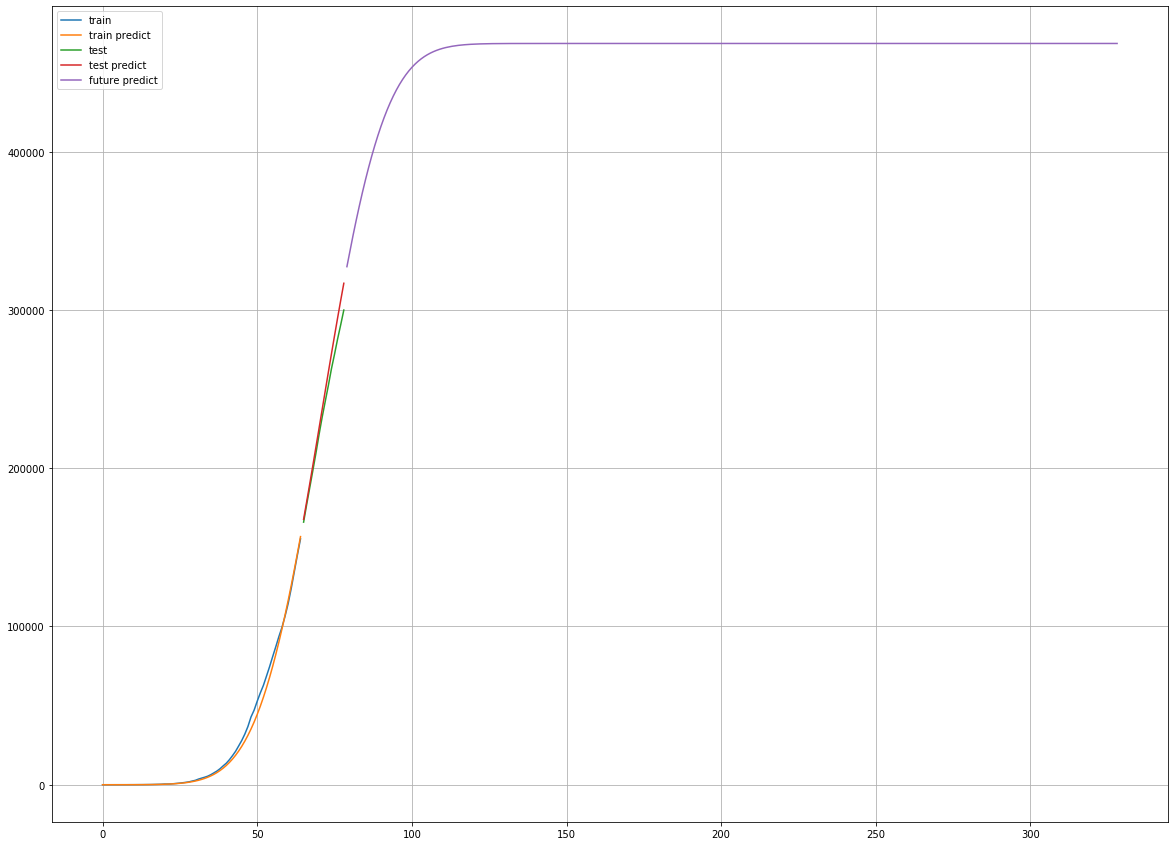

In [25]:
plot_with_train_size(prepare_data_raw_and_pred_bayes, 65)

### 3.c
Посэмплируйте много разных сигмоид из апостериорного распределения, постройте графики. Сколько, исходя из этих сэмплов, будет всего случаев коронавируса в России? Постройте эмпирическое предсказательное распределение, нарисуйте графики. Каков ваш прогноз числа случаев коронавируса в пессимистичном сценарии (90-й процентиль в выборке числа случаев)? В оптимистичном сценарии (10-й процентиль)?

In [26]:
def myplot_sample_sigmoids(mu, sigma, X, n=100):
    x_serie = X[['w1', 'w2']].to_numpy()
    results=[]
    my_w = np.random.multivariate_normal(mu, sigma, n)
    _, ax = plt.subplots(figsize=(20, 15), dpi=80)
    for w in my_w:
        pred_bayes_closure = lambda X: pred_bayes(X, w)
        _, ps_train = pred_sigmoid(pred_bayes_closure, x_serie)
        results.append(ps_train[-1])
        ax.plot(X['date'], ps_train, 'k-', lw=.4)
    pred_bayes_closure = lambda X: pred_bayes(X, mu)
    _, ps_train = pred_sigmoid(pred_bayes_closure, x_serie)
    results.append(ps_train[-1])
    ax.plot(X['date'], ps_train, linewidth = 2, label='max_loglikelihood')
    ax.grid(which='major', color = 'k', linewidth = .2)
    ax.set_ylabel('Total cases', fontsize=16)
    ax.set_xlabel('Date', fontsize=16)
    return results

10-й перцентиль 272231.8861955425
90-й перцентиль 906166.9346643655


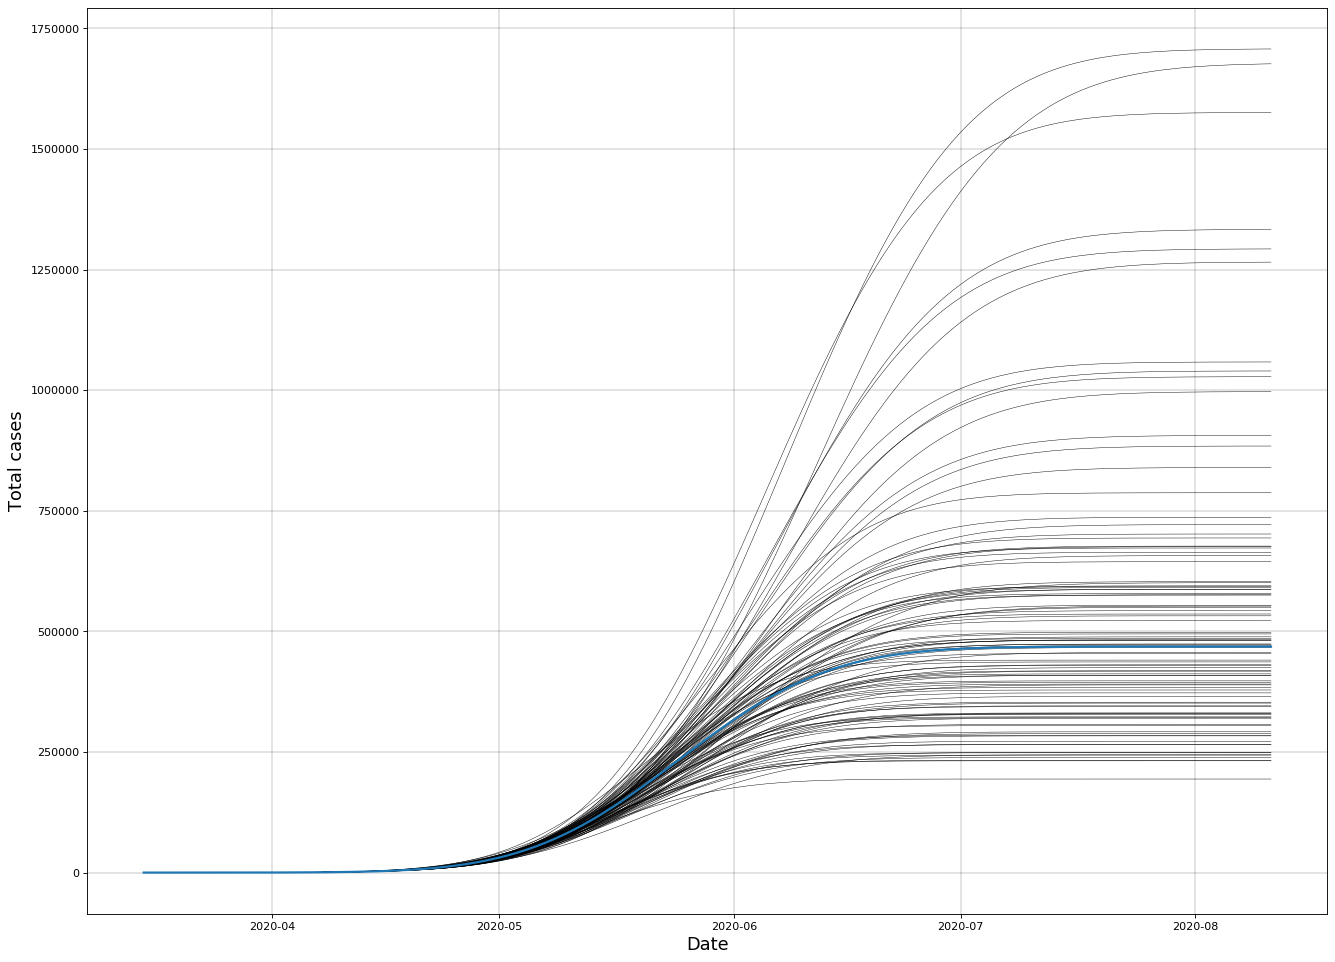

In [27]:
X = pd.DataFrame(get_square_arg(150))
X.columns = ['w1', 'w2']
start_date = datetime.datetime(2020, 3, 15)
X['date'] = X['w1'].apply(lambda x: start_date + datetime.timedelta(days=x))
_, param = prepare_data_raw_and_pred_bayes()
results = myplot_sample_sigmoids(param[0], param[1], X)
results.sort()
print("10-й перцентиль", results[len(results)//10])
print("90-й перцентиль", results[-len(results)//10])